<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Integrating Word2Vec Part2**


Estimated time needed: **40** minutes


This lab continues from **Integrating Word2Vec Part 1**, where you explored Skip-gram and CBOW models, learning how to build and apply them for text classification in PyTorch. You also integrated pretrained GloVe embeddings to enhance the models.

In this lab, an optional section on advanced embedding applications is available for further exploration. By the end, you will have gained proficiency in leveraging word embeddings for various natural language processing (NLP) tasks.


## __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-required-libraries">Installing required libraries</a></li>
            <li><a href="#Importing-Required-Libraries">Importing required libraries</a></li>
        </ol>
    </li>
    <li>
        <a href="#Background">Background</a>
        <ol>
            <li><a href="#GloVe-(Optional)">GloVe (Optional)</a></li>
        </ol>
    </li>
    <li>
            <a href="#Applying-pretrained-word-embeddings-(optional)">Applying pretrained word embeddings (optional)</a>
        <ol>
            <li><a href="#Load-Stanford-GloVe-model">Load Stanford GloVe model</a></li>
            <li><a href="#Train-a-word2vec-model-from-gensim">Train a word2vec model from gensim</a></li>
        </ol>
    </li>
    <li><a href="#Text-classification-using-pretrained-word-embeddings">Text classification using pretrained word embeddings</a></li>
</ol>



## Objectives

After completing this lab you will be able to:
- Get pretrained large embedding models and generate word embeddings with them.
- Train a word2vec model on a domain-specific data.


----


## Setup


For this lab, you will be using the following libraries:

*   [`torch`](https://pandas.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for building NN models and preparing the data.
*   [`numpy`](https://numpy.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for mathematical operations.
*   [`gensim`](https://pypi.org/project/gensim/) for word2vec pretrained models.
*   [`seaborn`](https://seaborn.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for visualizing the data.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for additional plotting tools.


### Installing required libraries


In [ ]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
#!mamba install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1
# Note: If your environment doesn't support "!mamba install", use "!pip install"

The following code removes **"utils.py"** if it already exists.


In [1]:
import os

if os.path.exists("utils.py"):
    os.remove("utils.py")
    print("utils.py deleted.")
else:
    print("utils.py not found.")


utils.py not found.


This script defines a **utility function**, **"find_similar_words"**, to identify words most similar to a given target word using word embeddings. It computes cosine similarity between word vectors to find the closest matches. This helps in NLP tasks like synonym discovery, word clustering, and semantic analysis.


In [13]:
%%writefile utils.py

import numpy as np

def find_similar_words(target_word, embedding_dict, top_k=2):
    if target_word not in embedding_dict:
        return f"Word '{target_word}' not found in embeddings."
    
    target_vector = embedding_dict[target_word]
    similarities = {}

    for word, vector in embedding_dict.items():
        if word == target_word:
            continue
        similarity = np.dot(target_vector, vector) / (np.linalg.norm(target_vector) * np.linalg.norm(vector))
        similarities[word] = similarity

    sorted_words = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return [word for word, _ in sorted_words[:top_k]]

Overwriting utils.py


In [ ]:
!pip install pandas==1.3.4
!pip install numpy==1.26.4
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn

The following required libraries are __not__ pre-installed in the Skills Network Labs environment. __You will need to run the following cell__ to install them:


In [ ]:
!pip install gensim #4.2.0
!pip install portalocker>=2.0.0
!pip install torch==2.2.2
!pip install torchdata==0.7.1
!pip install torchtext==0.17.2

<h3 style="color:red;">After installation, restart the kernel and run all cells from "Importing Required Libraries."</h3>


### Importing required libraries

_It is recommended that you import all required libraries in one place (here):_


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

from IPython.core.display import display, SVG


from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset


import logging
from gensim.models import Word2Vec
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import GloVe,vocab
from torchdata.datapipes.iter import IterableWrapper, Mapper
from torchtext.datasets import AG_NEWS
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader
from tqdm import tqdm
from utils import find_similar_words

%matplotlib inline

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')


/tmp/ipykernel_1144/4208393889.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, SVG


ModuleNotFoundError: No module named 'utils'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Background

In this lab session, you'll explore the GloVe model, and an **optional** summary is provided to enhance your understanding of its application in natural language processing.
## GloVe (Optional)



GloVe, on the other hand, is another popular algorithm for learning word embeddings. It stands for Global Vectors for Word Representation. Unlike word2vec, which is based on predicting context/target words, GloVe focuses on capturing the global word co-occurrence statistics from the entire corpus. It constructs a co-occurrence matrix that represents how often words appear together in the text. The matrix is then factorized to obtain the word embeddings. For example, if "Man" and "King" co-occure many times, their vectors will be simialr.

The GloVe model follows a fundamental approach by constructing a large word-context co-occurrence matrix that contains pairs of (word, context). Each entry in this matrix represents the frequency of a word occurring within a given context, which can be a sequence of words. The objective of the model is to utilize matrix factorization techniques to approximate this co-occurrence matrix. The process is illustrated in the following diagram:

1. Create a word-context co-occurrence matrix: The model begins by generating a matrix that captures the co-occurrence information of words and their surrounding contexts. Each element in the matrix represents how often a specific word and context pair co-occur in the training data.

2. Apply matrix factorization: Next, the GloVe model applies matrix factorization methods to approximate the word-context co-occurrence matrix. The goal is to decompose the original matrix into lower-dimensional representations that capture the semantic relationships between words and contexts.

3. Obtain word and context embeddings: By factorizing the co-occurrence matrix, the model obtains word and context embeddings. These embeddings are numerical representations that encode the semantic meaning and relationships of words and contexts.

To accomplish this, you can usually begin by initializing WF (Word-Feature matrix) and FC (Feature-Context matrix) with random weights.You will then perform a multiplication operation between these matrices to obtain WC' (an approximation of WC), and assess its similarity to WC. This process is repeated multiple times using Stochastic Gradient Descent (SGD) to minimize the error(WC'-WC).

Once the training is complete, the resulting Word-Feature matrix (WF) provides you with word embeddings or vector representations for each word(the green vector in the diagram). The dimensionality of the embedding vectors can be predetermined by setting the value of F to a specific number of dimensions, allowing for a compact representation of the word semantics.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/matrix%20fact.png" alt="Co-occurence matrix" class="bg-primary" width="600px">

The key advantage of GloVe is that it can incorporate both global statistics and local context information. This results in word embeddings that not only capture the semantic relationships between words but also preserve certain syntactic relationships.


# Applying pretrained word embeddings (optional)
## Load Stanford GloVe model

Transfer learning, particularly through the use of pretrained word embeddings, serves as a cornerstone in modern NLP. This approach leverages knowledge gleaned from one task, typically learned over massive datasets, and applies it to another, often more specialized task. The primary advantage of this is twofold: it bypasses the need for enormous computational resources to learn from scratch, and it injects a base layer of linguistic understanding into the model. By using embeddings that have already captured complex language patterns and associations, even models with limited exposure to domain-specific data can exhibit remarkably sophisticated behavior, making transfer learning a strategic shortcut to enhanced performance in NLP.


Let's take a look at the pretrained GloVe model from Stanford:


You can specify the model name and embedding dimension: GloVe(name='GloVe_model_name', dim=300)


In [5]:
# creating an instance of the 6B version of Glove() model
glove_vectors_6B = GloVe(name ='6B') # you can specify the model with the following format: GloVe(name='840B', dim=300)

.vector_cache/glove.6B.zip: 862MB [02:41, 5.32MB/s]                               
100%|█████████▉| 399999/400000 [00:42<00:00, 9405.10it/s] 


In [6]:
# creating another instance of a bigger Glove() model
#glove_vectors_840B = GloVe()

You must continue with the 6B model as it is lighter. You can load different pretrained GloVe models from torch() using ```torch.nn.Embedding.from_pretrained```. 


In [7]:
# load the glove model pretrained weights into a PyTorch embedding layer
embeddings_Glove6B = torch.nn.Embedding.from_pretrained(glove_vectors_6B.vectors,freeze=True)

Get ready to look into the embedding vectors of this large pretrained model for the words in the corpus:


You can create an array that returns the index of each word in the GloVe model's vocabulary:


In [8]:
word_to_index = glove_vectors_6B.stoi  # Vocabulary index mapping
word_to_index['team']

145

You will get the embedded vector for a word:


In [9]:
embeddings_Glove6B.weight[word_to_index['team']]

tensor([-2.7011e-02,  1.1299e+00,  4.4708e-02, -4.0380e-01, -4.7284e-02,
         9.2736e-02, -2.0715e-01,  2.6137e-01,  2.4730e-01, -8.8769e-01,
         3.1309e-01, -1.4940e-01,  4.9929e-03, -1.1520e-01, -1.7990e-01,
         6.4681e-01,  1.5044e-01, -3.4580e-01,  2.3370e-03, -7.5788e-01,
         1.6048e-01, -2.9066e-02,  1.7194e-01, -4.2799e-02,  3.4297e-02,
        -1.1400e-01, -2.1149e-01,  3.6118e-01, -3.3393e-01, -1.3581e-01,
         1.7858e-01, -2.3381e-01, -8.3367e-02,  1.0626e-01, -1.7301e+00,
         5.2052e-01,  3.7855e-01,  5.5852e-01, -1.0172e-01, -1.8644e-01,
        -1.2096e-01, -5.2009e-02,  1.9565e-01, -1.2685e-01, -3.7493e-01,
         9.7457e-02,  1.7014e-01,  7.7521e-02, -2.1946e-01,  1.4490e-01,
         1.2733e-01, -2.2223e-01, -3.1548e-01,  1.1137e-01, -4.0263e-01,
         8.3553e-01, -7.5475e-03,  3.6725e-01,  1.2324e-02, -1.0033e-01,
        -6.0014e-01,  4.2763e-01, -2.4048e-01, -2.8162e-01,  4.6409e-02,
        -3.7942e-01, -8.0836e-02, -3.2884e-01, -9.3

Let's see how successful the Glove model is in capturing the similarities between words:


In [10]:
# an array of example words
words = [
    "taller",
    "short",
    "black",
    "white",
    "dress",
    "pants",
    "big",
    "small",
    "red",
    "blue",
    "smile",
    "frown",
    "race",
    "stroll",
    "tiny",
    "huge",
    "soft",
    "rough",
    "team",
    "individual"
]


Create a dictionary of words and their embeddings


In [11]:

embedding_dict_Glove6B = {}
for word in words:
    # Get the index of the word from the vocabulary to access its embedding
    embedding_vector = embeddings_Glove6B.weight[word_to_index[word]]
    if embedding_vector is not None:
        # Words not found in the embedding index will be skipped.
        # add the embedding vector of word to the embedding_dict_Glove6B
        embedding_dict_Glove6B[word] = embedding_vector


Now that you have loaded the pretrained embeddings for the sample words, let's check if the model can capture the similarity of words by finding the distance between words:


In [15]:
from utils import find_similar_words

ModuleNotFoundError: No module named 'utils'

In [16]:
def find_similar_words(target_word, embedding_dict, top_k=2):
    if target_word not in embedding_dict:
        return f"Word '{target_word}' not found in embeddings."
    
    target_vector = embedding_dict[target_word]
    similarities = {}

    for word, vector in embedding_dict.items():
        if word == target_word:
            continue
        similarity = np.dot(target_vector, vector) / (np.linalg.norm(target_vector) * np.linalg.norm(vector))
        similarities[word] = similarity

    sorted_words = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return [word for word, _ in sorted_words[:top_k]]

In [17]:
# Call the function to find similar words
target_word = "small"
top_k=2
similar_words = find_similar_words(target_word, embedding_dict_Glove6B, top_k)

# Print the similar words
print("{} most similar words to {}:".format(top_k,target_word) ,similar_words)

2 most similar words to small: ['tiny', 'big']


It can be seen the pretrained GloVe model does quite good job capturing the similarity of words.


# Train a word2vec model from gensim

Here's a simple hands-on exercise to train a word2vec model using `gensim` library.
In this example, you have a small corpus consisting of four sentences. 

### Prepare your corpus:


In [18]:
sentences = [["I", "like", "to", "eat", "pizza"],
             ["Pizza", "is", "my", "favorite", "food"],
             ["I", "enjoy", "eating", "pasta"]]
sentences = [[word.lower() for word in sentence] for sentence in sentences]


The `size` parameter specifies the dimensionality of the word embeddings (in this case, 100). The `window` parameter determines the size of the context window. The `min_count` parameter sets the minimum frequency of a word to be included in the training process. Finally, the `workers` parameter controls the number of threads used for training.


In [19]:
from gensim.models import Word2Vec

# Create an instance of Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=100, window=3, min_count=1, workers=4)

Create vocab from sentences:


In [20]:
# Build vocab using the training data
w2v_model.build_vocab(sentences, progress_per=10000)

Train the model:


In [21]:
# Train the model on your training data
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(55, 420)

That's it! You've trained a word2vec model using the `gensim` library. You can now access the word embeddings using `model.wv` and explore various operations such as finding similar words, calculating word similarities, and more.


Use the trained model to find similar words to "pizza" and calculate the similarity between "pizza" and "pasta". 


In [22]:
# Finding similar words
similar_words = w2v_model.wv.most_similar("pizza")
print("Similar words to 'pizza':", similar_words)

# Calculating word similarity
similarity = w2v_model.wv.similarity("pizza", "pasta")
print("Similarity between 'pizza' and 'pasta':", similarity)

Similar words to 'pizza': [('to', 0.170244961977005), ('is', 0.1390952169895172), ('my', 0.03540320321917534), ('like', 0.004472944885492325), ('pasta', -0.005862740334123373), ('i', -0.02750754915177822), ('favorite', -0.027992047369480133), ('eat', -0.044601183384656906), ('food', -0.06864096224308014), ('enjoy', -0.17301428318023682)]
Similarity between 'pizza' and 'pasta': -0.005862741


The word embeddings obtained from the model would be more meaningful and informative with larger and more diverse training data.


Use the trained model to create a PyTorch embedding layer (just like what you did with the pretrained GloVe model) and use it in any task as an embedding layer.


In [23]:
# Extract word vectors and create word-to-index mapping
word_vectors = w2v_model.wv
# a dictionary to map words to their index in vocab
word_to_index = {word: index for index, word in enumerate(word_vectors.index_to_key)}

# Create an instance of nn.Embedding and load it with the trained vectors
embedding_dim = w2v_model.vector_size
embedding = torch.nn.Embedding(len(word_vectors.index_to_key), embedding_dim)
embedding.weight.data.copy_(torch.from_numpy(word_vectors.vectors))

# Example usage: get the embedding for a word
word = "pizza"
word_index = word_to_index[word]
word_embedding = embedding(torch.LongTensor([word_index]))
print(f"Word: {word}, Embedding: {word_embedding.detach().numpy()}")

Word: pizza, Embedding: [[-0.00714022  0.00123998 -0.00717622 -0.0022417   0.00371598  0.00583061
   0.00120213  0.00210559 -0.00411537  0.00722163 -0.00630376  0.0046457
  -0.00822015  0.00203703 -0.00497838 -0.0042473  -0.00310639  0.00565345
   0.00579695 -0.00498193  0.00077337 -0.00849349  0.00781617  0.0092573
  -0.00274196  0.00080025  0.0007445   0.0054774  -0.00860765  0.00058363
   0.00687292  0.00223263  0.00112718 -0.00932121  0.00847941 -0.00626033
  -0.00299176  0.00349312 -0.00077406  0.00140831  0.00178567 -0.00682942
  -0.00972678  0.00903786  0.0061995  -0.0069122   0.00339904  0.00020766
   0.00475404 -0.00711863  0.00402571  0.00434621  0.00995607 -0.00447163
  -0.00139091 -0.00732117 -0.0096983  -0.00908488 -0.00102354 -0.00650586
   0.00484972 -0.00616477  0.00252523  0.0007378  -0.00339542 -0.00097725
   0.00997474  0.00914589 -0.00446644  0.00907925 -0.00564109  0.00593694
  -0.0030968   0.0034326   0.0030185   0.00689902 -0.00237263  0.00877459
   0.00758869 -0

# Text classification using pretrained word embeddings

You are ready to use the embeddings in a task, then. Let's use the pretrained embeddings to classify text data into topics:


First, you must build vocab from the pretrained GloVe:


In [24]:
from torchtext.vocab import GloVe,vocab
# Build vocab from glove_vectors
# vocab(ordered_dict: Dict, min_freq: int = 1, specials: Optional[List[str]] = None)
vocab = vocab(glove_vectors_6B.stoi, 0,specials=('<unk>', '<pad>'))
vocab.set_default_index(vocab["<unk>"])

In [25]:
vocab(["<unk>","Hello","hello"])

[0, 0, 13077]

Next, you need to tokenize text. For this you can use pretrained tokenizers from torch:


In [26]:
# Define tokenizer

tokenizer = get_tokenizer("basic_english")
# Define functions to process text and labels

Create splits from AG_NEWS() dataset for training, validation and test:


In [27]:
# Split the dataset into training and testing iterators.
train_iter, test_iter = AG_NEWS()

# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.85)

# Randomly split the training dat aset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

Define the class labels:


In [28]:
# define class labels
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
'''ag_news_label[y]'''
num_class = len(set([label for (label, text) in train_iter ]))

Collate data in batches:


In [29]:
def text_pipeline(x):
    x=x.lower()# you need this as your vocab is in lower case
    return vocab(tokenizer(x))

def label_pipeline(x):
    return int(x) - 1

# create label, text and offset for each batch of data
# text is the concatenated text for all text data in the batch
# you need to have the offsets(the end of text index) for later when you separate texts and predict their label
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)


Create data loaders for train, validation and test splits:


In [30]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [31]:
label, text, offsets=next(iter(train_dataloader ))
print(label, text, offsets)
label.shape, text.shape, offsets.shape

tensor([3, 2, 2, 1, 2, 1, 3, 2, 2, 0, 3, 3, 0, 3, 3, 3, 2, 0, 0, 1, 0, 0, 2, 0,
        2, 1, 3, 2, 1, 3, 3, 2, 3, 3, 2, 0, 2, 0, 2, 1, 0, 2, 1, 3, 2, 2, 2, 2,
        1, 1, 3, 2, 1, 1, 0, 1, 3, 2, 3, 3, 3, 2, 2, 0]) tensor([14842,     7,  2060,  ...,     4,     4,     4]) tensor([   0,   82,  133,  173,  201,  241,  292,  320,  364,  399,  429,  484,
         524,  565,  636,  684,  707,  735,  791,  865,  897,  933,  974, 1027,
        1076, 1116, 1153, 1207, 1222, 1264, 1317, 1339, 1384, 1434, 1484, 1539,
        1583, 1651, 1703, 1743, 1784, 1827, 1876, 1908, 1956, 1985, 2020, 2062,
        2108, 2148, 2188, 2226, 2262, 2310, 2362, 2413, 2439, 2488, 2522, 2569,
        2611, 2651, 2693, 2734, 2826])


(torch.Size([64]), torch.Size([2826]), torch.Size([65]))

Create the classifier model:


In [32]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(glove_vectors_6B.vectors,freeze=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text,offsets):
        embedded = self.embedding(text)
        # you get the average of word embeddings in the text
        means = []
        for i in range(1,len(offsets)):
            #this is like eme
          text_tmp = embedded[offsets[i-1]:offsets[i]]
          means.append(text_tmp.mean(0))

        return self.fc(torch.stack(means))

Define an evaluate function to calculate the accuracy of model:


In [33]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text,offsets)

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

Create an instance of the model and check its prediction power before training:


In [34]:
# Define hyperparameters
vocab_size=len(vocab)
embedding_dim = 300
# Initialize the model
model = TextClassificationModel(vocab_size, embedding_dim, num_class).to(device)

In [35]:
evaluate(test_dataloader)

0.24473684210526317

Not good! Let's train the model:


In [36]:
def train_TextClassification(model,dataloader,criterion,optimizer,epochs=10):
    
    cum_loss_list=[]
    acc_epoch=[]
    acc_old=0

    for epoch in tqdm(range(1, EPOCHS + 1)):
        model.train()
        cum_loss=0
        for idx, (label, text, offsets) in enumerate(train_dataloader):
            means = []
            optimizer.zero_grad()
            

            predicted_label = model(text, offsets)
            
            loss = criterion(predicted_label, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            cum_loss+=loss.item()

        cum_loss_list.append(cum_loss/len(train_dataloader))
        accu_val = evaluate(valid_dataloader)
        acc_epoch.append(accu_val)

        if accu_val > acc_old:
          acc_old= accu_val
          torch.save(model.state_dict(), 'my_model.pth')
            
    return model,cum_loss_list,acc_epoch


In [37]:
# Define hyperparameters
LR=0.1
EPOCHS = 10


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

model,cum_loss_list,acc_epoch  = train_TextClassification(model,train_dataloader,criterion,optimizer,EPOCHS)

100%|██████████| 10/10 [07:37<00:00, 45.73s/it]


Let's plot the loss and accuracy for the trained model:


In [38]:
import matplotlib.pyplot as plt
def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

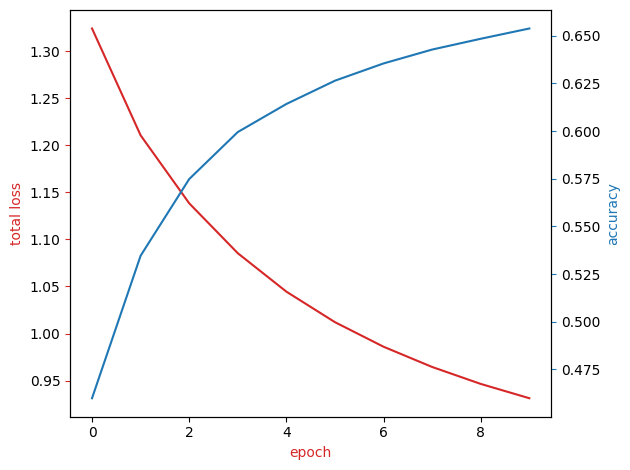

In [39]:
plot(cum_loss_list,acc_epoch)

Finally, evaluate the model on test data:


In [40]:
evaluate(test_dataloader)

0.65

Great job! You've acquired the skills to create and train embedding models, as well as utilize large pretrained models for practical applications. This knowledge opens up a world of possibilities where you can leverage the power of embeddings to improve various natural language processing tasks. Keep up the excellent work!


## Authors


Fateme Akbari


```{## Change Log}
```


```{|Date (YYYY-MM-DD)|Version|Changed By|Change Description||-|-|-|-||2023-10-16|0.1|Fateme|Create Lab Template|}
```


© Copyright IBM Corporation. All rights reserved.
